In [61]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import chisquare, pearsonr, ttest_ind

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
df = pd.read_csv('datasets/TwitCID/firstweek_features_binary_subset.csv').drop('Unnamed: 0', axis=1)

In [3]:
df.head()

Has_location  Has_username  Followers  Followees  Age_account  \
0             0             0   970218.0      541.0       2762.0   
1             0             1     7004.0      637.0       2856.0   
2             0             0        6.0       44.0        613.0   
3             0             0      322.0      107.0        453.0   
4             0             0     2009.0      255.0       2455.0   

   Total_tweets  Favourite  Groups  Has_Image  Aver_favourite  ...  \
0         346.0    29061.0   562.0          0           10.52  ...   
1       10905.0     3755.0    19.0          0            1.31  ...   
2       56428.0        0.0     0.0          0            0.00  ...   
3       13480.0     6952.0    19.0          0           15.35  ...   
4       55705.0      322.0   519.0          0            0.13  ...   

   Has_tvshow  Posted_noon  Posted_weeke  Posted_eve Has_excl  Num_hashtag  \
0           0            0             1           0        0          1.0   
1           0            0             0           1        0          0.0   
2           0            0             0           1        0          0.0   
3           0            0             0           0        0          0.0   
4           0            0             0           0        0          2.0   

   Opt_len  Has_suggest  Has_video  @@class@@  
0        0            0          0          1  
1        0            0          0          0  
2        0            0          0          0  
3        0            0          0          0  
4        0            0          0          0  

[5 rows x 30 columns]

In [4]:
df.columns

Index(['Has_location', 'Has_username', 'Followers', 'Followees', 'Age_account',
       'Total_tweets', 'Favourite', 'Groups', 'Has_Image', 'Aver_favourite',
       'Length_tweet', 'Aver_tweets', 'Contain_URL', 'Name_length',
       'Sent_level', 'Has_Uword', 'Posted_holiday', 'Has_number', 'Has_rt',
       'Has_org', 'Has_tvshow', 'Posted_noon', 'Posted_weeke', 'Posted_eve',
       'Has_excl', 'Num_hashtag', 'Opt_len', 'Has_suggest', 'Has_video',
       '@@class@@'],
      dtype='object')

In [5]:
df.shape

(80000, 30)

In [6]:
np.unique(df.Opt_len)

array([0, 1], dtype=int64)

In [7]:
continuous = df[['Followers',
                 'Followees',
                 'Age_account',
                 'Total_tweets',
                 'Favourite', 
                 'Groups', 
                 'Aver_favourite', 
                 'Length_tweet',
                 'Aver_tweets',
                 'Name_length',
                 '@@class@@']]

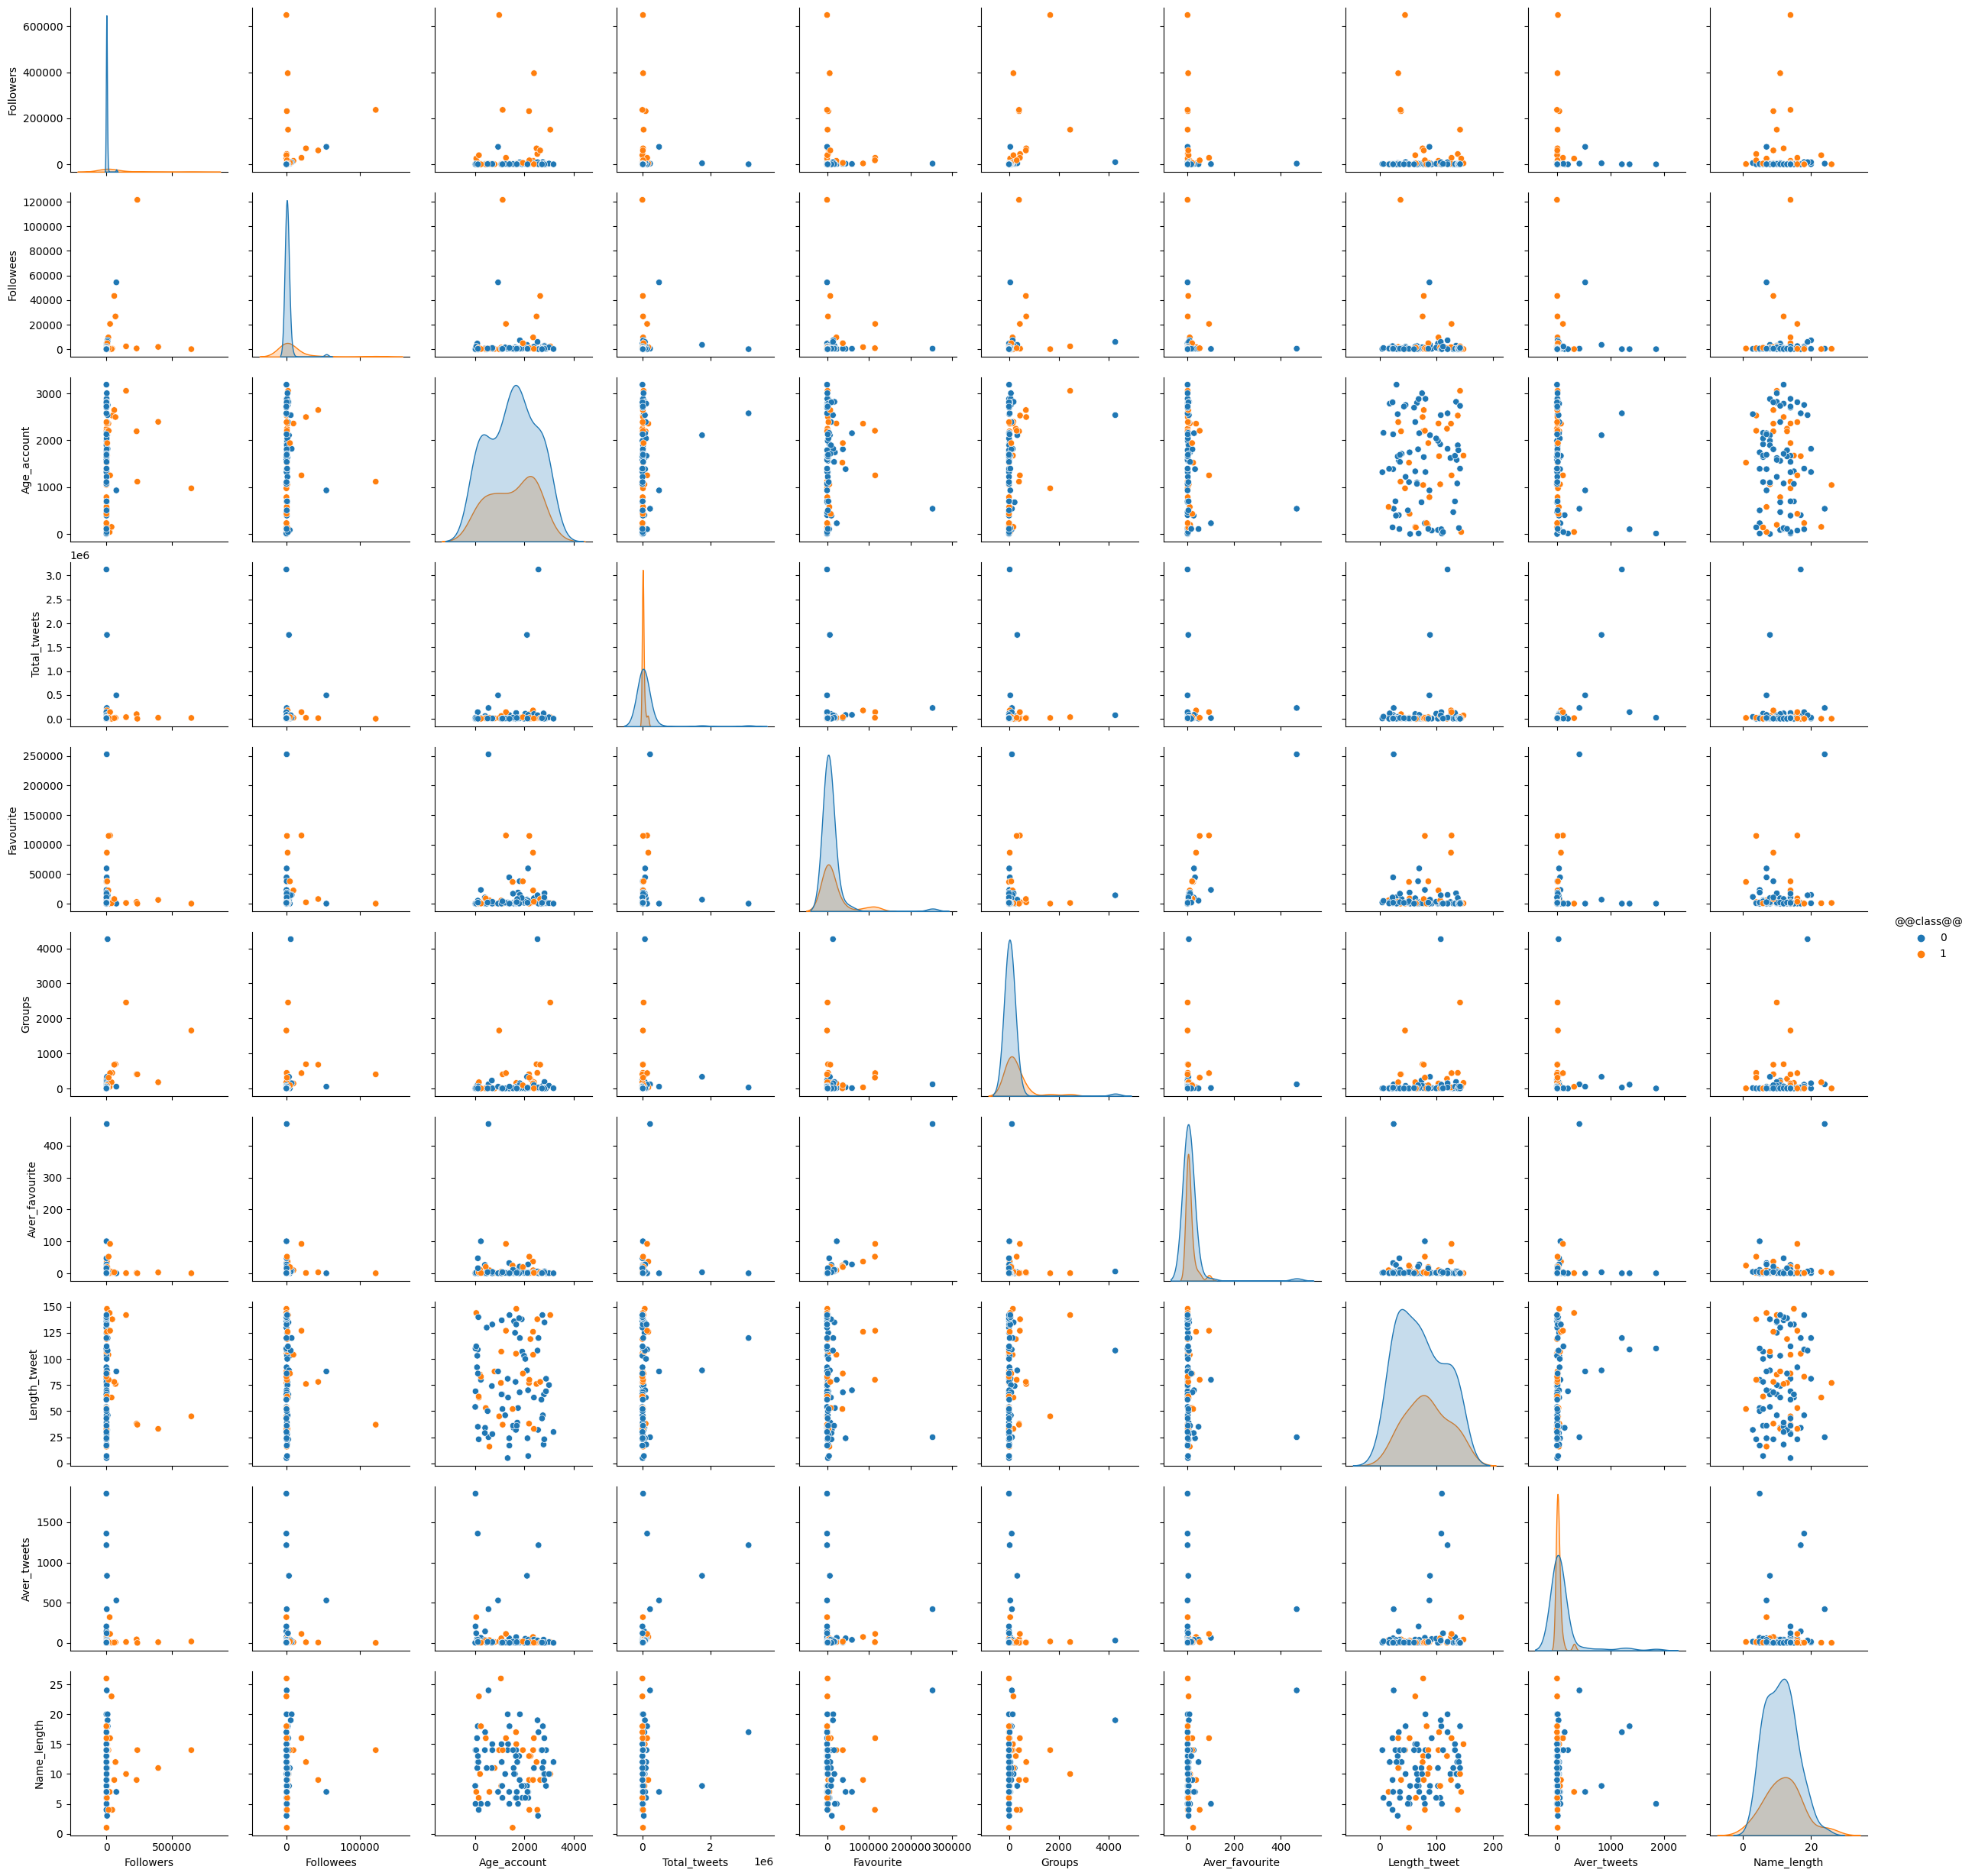

In [8]:
p = sns.pairplot(continuous.sample(100), hue="@@class@@")

In [9]:
continuous.drop('@@class@@', axis=1).corr()

Followers  Followees  Age_account  Total_tweets  Favourite  \
Followers        1.000000   0.125900     0.092481      0.016311  -0.008381   
Followees        0.125900   1.000000     0.071485      0.074790   0.071022   
Age_account      0.092481   0.071485     1.000000      0.108449   0.076547   
Total_tweets     0.016311   0.074790     0.108449      1.000000   0.104644   
Favourite       -0.008381   0.071022     0.076547      0.104644   1.000000   
Groups           0.835353   0.128841     0.101707      0.035707   0.004851   
Aver_favourite  -0.012219   0.016325    -0.129973      0.029115   0.487257   
Length_tweet     0.028428   0.041790     0.070170      0.063874  -0.012786   
Aver_tweets     -0.009318   0.006189    -0.201174      0.461950   0.010001   
Name_length     -0.001837   0.036000     0.013719      0.032668  -0.013811   

                  Groups  Aver_favourite  Length_tweet  Aver_tweets  \
Followers       0.835353       -0.012219      0.028428    -0.009318   
Followees       0.128841        0.016325      0.041790     0.006189   
Age_account     0.101707       -0.129973      0.070170    -0.201174   
Total_tweets    0.035707        0.029115      0.063874     0.461950   
Favourite       0.004851        0.487257     -0.012786     0.010001   
Groups          1.000000       -0.005512      0.036599    -0.001485   
Aver_favourite -0.005512        1.000000     -0.012451     0.072378   
Length_tweet    0.036599       -0.012451      1.000000     0.071911   
Aver_tweets    -0.001485        0.072378      0.071911     1.000000   
Name_length     0.002917       -0.005016      0.140497     0.010916   

                Name_length  
Followers         -0.001837  
Followees          0.036000  
Age_account        0.013719  
Total_tweets       0.032668  
Favourite         -0.013811  
Groups             0.002917  
Aver_favourite    -0.005016  
Length_tweet       0.140497  
Aver_tweets        0.010916  
Name_length        1.000000

In [10]:
def calc_ttest(df, pred, resp, values):
    assert len(values) == 2
    
    subset1 = df[df[resp] == values[0]]
    subset2 = df[df[resp] == values[1]]
    
    return ttest_ind(subset1[pred], subset2[pred], equal_var=False)

In [11]:
calc_ttest(continuous, 'Aver_tweets', '@@class@@', [0, 1])

Ttest_indResult(statistic=34.1177492935263, pvalue=4.159817803013098e-253)

In [12]:
def filter_significant_t(df, cls, alpha):
    col_list = []
    columns = list(df.columns)
    columns.remove(cls)
    
    for col in columns:
        result = calc_ttest(df, col, cls, [0, 1])
        
        if result.pvalue <= alpha:
            col_list.append(col)
    
    return df[col_list]

In [13]:
significant_continuous = filter_significant_t(continuous, '@@class@@', 0.05)

In [14]:
significant_continuous.head()

Followers  Followees  Age_account  Total_tweets  Favourite  Groups  \
0   970218.0      541.0       2762.0         346.0    29061.0   562.0   
1     7004.0      637.0       2856.0       10905.0     3755.0    19.0   
2        6.0       44.0        613.0       56428.0        0.0     0.0   
3      322.0      107.0        453.0       13480.0     6952.0    19.0   
4     2009.0      255.0       2455.0       55705.0      322.0   519.0   

   Aver_favourite  Length_tweet  Aver_tweets  Name_length  
0           10.52         104.0         0.13          5.0  
1            1.31          29.0         3.82         15.0  
2            0.00          87.0        92.05          9.0  
3           15.35          65.0        29.76         15.0  
4            0.13         128.0        22.69         18.0

In [15]:
u, c = np.unique(df['@@class@@'], return_counts=True)
c

array([53184, 26816], dtype=int64)

In [16]:
discrete = df.drop(['Followers',
                 'Followees',
                 'Age_account',
                 'Total_tweets',
                 'Favourite', 
                 'Groups', 
                 'Aver_favourite', 
                 'Length_tweet',
                 'Aver_tweets',
                 'Name_length'], axis=1)

In [17]:
def calc_chisquare(df, pred, resp, value, silent=False):
    subset = df[df[resp] == value]
    true_unique, true_counts = np.unique(df[pred], return_counts=True)
    
    unique, counts = np.unique(subset[pred], return_counts=True)
    sample_counts = np.zeros(len(true_counts))
    
    for attr, count in zip(unique, counts):
        pos = np.where(true_unique == attr)[0][0]
        sample_counts[pos] = count
        
    scaled_counts = len(df)*sample_counts/len(subset)
    if not silent:
        print(scaled_counts)
        print(true_counts)
    return chisquare(scaled_counts, true_counts)

In [18]:
calc_chisquare(discrete, 'Num_hashtag', '@@class@@', 1)

[6.05101432e+04 1.13245823e+04 3.77983294e+03 2.62231504e+03
 8.23389021e+02 4.11694511e+02 2.47613365e+02 1.22315036e+02
 7.45823389e+01 4.77326969e+01 2.38663484e+01 5.96658711e+00
 0.00000000e+00 5.96658711e+00 0.00000000e+00]
[62096 10238  3402  2271   868   488   319   148    73    48    31    11
     3     3     1]


Power_divergenceResult(statistic=297.70325954141043, pvalue=3.5603293864700106e-55)

In [19]:
len(df)

80000

In [20]:
for col in discrete.columns:
    if col != '@@class@@':
        print(col+':')
        print(0, end=': ')
        print(calc_chisquare(discrete, col, '@@class@@', 0, silent=True))
        print(1, end=': ')
        print(calc_chisquare(discrete, col, '@@class@@', 1, silent=True))

Has_location:
0: Power_divergenceResult(statistic=18.268959963179228, pvalue=1.9180723862897668e-05)
1: Power_divergenceResult(statistic=71.86010139571447, pvalue=2.3100792751048245e-17)
Has_username:
0: Power_divergenceResult(statistic=739.0664157792197, pvalue=9.567084502437988e-163)
1: Power_divergenceResult(statistic=2907.0832539511234, pvalue=0.0)
Has_Image:
0: Power_divergenceResult(statistic=2074.1574689789636, pvalue=0.0)
1: Power_divergenceResult(statistic=8158.601602494757, pvalue=0.0)
Contain_URL:
0: Power_divergenceResult(statistic=870.5714347268525, pvalue=2.4510677507939724e-191)
1: Power_divergenceResult(statistic=3424.3521085913735, pvalue=0.0)
Sent_level:
0: Power_divergenceResult(statistic=120.30294479717337, pvalue=7.525709653132712e-27)
1: Power_divergenceResult(statistic=473.2060187745616, pvalue=1.7563805592194268e-103)
Has_Uword:
0: Power_divergenceResult(statistic=51.83698940997765, pvalue=6.030495482773079e-13)
1: Power_divergenceResult(statistic=203.8983785917

In [21]:
def filter_significant_x2(df, cls, alpha):
    col_list = []
    columns = list(df.columns)
    columns.remove(cls)
#     print(columns)
    
    for col in columns:
        result0 = calc_chisquare(df, col, cls, 0, silent=True)
        result1 = calc_chisquare(df, col, cls, 1, silent=True)
        
        if result0.pvalue <= alpha or result1.pvalue <= alpha:
            col_list.append(col)
    
    return df[col_list]

In [22]:
significant_discrete = filter_significant_x2(discrete, '@@class@@', 0.05)

In [23]:
significant_discrete.head()

Has_location  Has_username  Has_Image  Contain_URL        Sent_level  \
0             0             0          0            0          negative   
1             0             1          0            0  neutro_objective   
2             0             0          0            1          negative   
3             0             0          0            1          negative   
4             0             0          0            1          negative   

   Has_Uword  Posted_holiday  Has_number  Has_rt  Has_org  Has_tvshow  \
0          0               1           1       0        0           0   
1          0               1           0       0        0           0   
2          0               0           0       0        0           0   
3          1               1           0       0        0           0   
4          0               1           1       0        0           0   

   Posted_noon  Posted_eve  Num_hashtag  Opt_len  Has_suggest  Has_video  
0            0           0          1.0        0            0          0  
1            0           1          0.0        0            0          0  
2            0           1          0.0        0            0          0  
3            0           0          0.0        0            0          0  
4            0           0          2.0        0            0          0

In [24]:
def numerify(x):
    if x == 'positive':
        return 1
    if x == 'negative':
        return -1
    else:
        return 0

Sent_level = significant_discrete['Sent_level'].apply(numerify)
significant_discrete.drop('Sent_level', axis=1)
significant_discrete = significant_discrete.assign(Sent_level = Sent_level)

In [25]:
np.unique(significant_discrete['Sent_level'])

array([-1,  0,  1], dtype=int64)

In [26]:
significant = significant_discrete.join(significant_continuous)
significant.head()

Has_location  Has_username  Has_Image  Contain_URL  Sent_level  Has_Uword  \
0             0             0          0            0          -1          0   
1             0             1          0            0           0          0   
2             0             0          0            1          -1          0   
3             0             0          0            1          -1          1   
4             0             0          0            1          -1          0   

   Posted_holiday  Has_number  Has_rt  Has_org  ...  Followers  Followees  \
0               1           1       0        0  ...   970218.0      541.0   
1               1           0       0        0  ...     7004.0      637.0   
2               0           0       0        0  ...        6.0       44.0   
3               1           0       0        0  ...      322.0      107.0   
4               1           1       0        0  ...     2009.0      255.0   

   Age_account  Total_tweets  Favourite  Groups  Aver_favourite  Length_tweet  \
0       2762.0         346.0    29061.0   562.0           10.52         104.0   
1       2856.0       10905.0     3755.0    19.0            1.31          29.0   
2        613.0       56428.0        0.0     0.0            0.00          87.0   
3        453.0       13480.0     6952.0    19.0           15.35          65.0   
4       2455.0       55705.0      322.0   519.0            0.13         128.0   

   Aver_tweets  Name_length  
0         0.13          5.0  
1         3.82         15.0  
2        92.05          9.0  
3        29.76         15.0  
4        22.69         18.0  

[5 rows x 27 columns]

In [27]:
X, y = significant, discrete['@@class@@']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Decision Tree

In [29]:
alpha = 0.0002

In [30]:
model = DecisionTreeClassifier(criterion='gini', random_state=4221323, ccp_alpha=alpha)
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0002, random_state=4221323)

In [31]:
y_pred = model.predict(X_test)

In [32]:
accuracy_score(y_test, y_pred)

0.8003125

In [33]:
y_pred_train = model.predict(X_train)

In [34]:
accuracy_score(y_train, y_pred_train)

0.80990625

In [35]:
np.unique(y_pred,return_counts=True)

(array([0, 1], dtype=int64), array([11692,  4308], dtype=int64))

In [36]:
np.unique(y_test,return_counts=True)

(array([0, 1], dtype=int64), array([10637,  5363], dtype=int64))

In [37]:
plt.figure(figsize=(200, 150))
plot_tree(model, feature_names=significant.columns);

In [38]:
importances = dict(zip(significant.columns, model.feature_importances_))

In [39]:
from pprint import PrettyPrinter
pp = PrettyPrinter()
pp.pprint({k:importances[k] for k in importances.keys() if importances[k] != 0})

{'Age_account': 0.0076685513136453345,
 'Aver_favourite': 0.04704064488519919,
 'Aver_tweets': 0.016245134586247555,
 'Contain_URL': 0.016956201304229614,
 'Favourite': 0.01335744157621727,
 'Followees': 0.008918353268532606,
 'Followers': 0.7145622950112746,
 'Groups': 0.004095826649308135,
 'Has_Image': 0.048294847297094365,
 'Has_username': 0.03504175561603755,
 'Has_video': 0.0012341359357824558,
 'Length_tweet': 0.030758371007799757,
 'Num_hashtag': 0.014450139478940478,
 'Total_tweets': 0.041376302069690986}


In [40]:
cm = confusion_matrix(y_test, y_pred)

<AxesSubplot: >

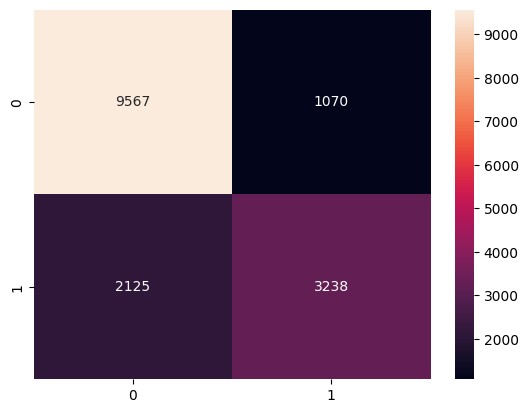

In [41]:
sns.heatmap(cm, annot=True, fmt="")

In [42]:
df2 = pd.read_csv('datasets/TwitCID/secondweek_features_binary.csv').drop('Unnamed: 0', axis=1)

In [43]:
continuous = df[['Followers',
                 'Followees',
                 'Age_account',
                 'Total_tweets',
                 'Favourite', 
                 'Groups', 
                 'Aver_favourite', 
                 'Length_tweet',
                 'Aver_tweets',
                 'Name_length',
                 '@@class@@']]

In [44]:
discrete = df.drop(['Followers',
                 'Followees',
                 'Age_account',
                 'Total_tweets',
                 'Favourite', 
                 'Groups', 
                 'Aver_favourite', 
                 'Length_tweet',
                 'Aver_tweets',
                 'Name_length'], axis=1)

In [45]:
significant_continuous = filter_significant_t(continuous, '@@class@@', 0.05)
significant_discrete = filter_significant_x2(discrete, '@@class@@', 0.05)
Sent_level = significant_discrete['Sent_level'].apply(numerify)
significant_discrete.drop('Sent_level', axis=1)
significant_discrete = significant_discrete.assign(Sent_level = Sent_level)

In [46]:
X, y = significant, discrete['@@class@@']

In [47]:
y_pred = model.predict(X)
accuracy_score(y, y_pred)

0.8079875

# Naive-Bayes

In [51]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [58]:
y_pred = gnb.predict(X_test)
accuracy_score(y_test, y_pred)

0.705125

<AxesSubplot: >

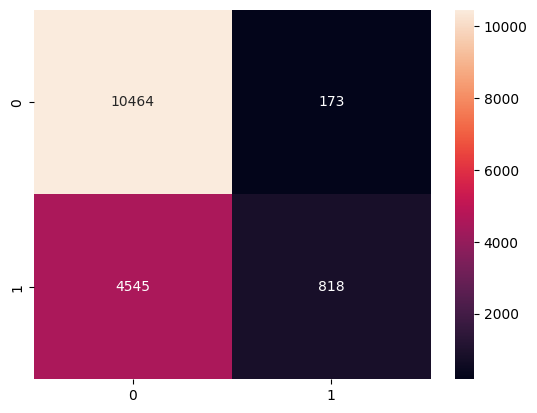

In [59]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="")

In [54]:
y_pred_train = gnb.predict(X_train)
accuracy_score(y_train, y_pred_train)

0.706

In [56]:
y_pred = gnb.predict(X)
accuracy_score(y, y_pred)

0.705825

# SVM with radial

In [64]:
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

SVC()

In [65]:
y_pred = svm.predict(X_test)
accuracy_score(y_test, y_pred)

0.736

<AxesSubplot: >

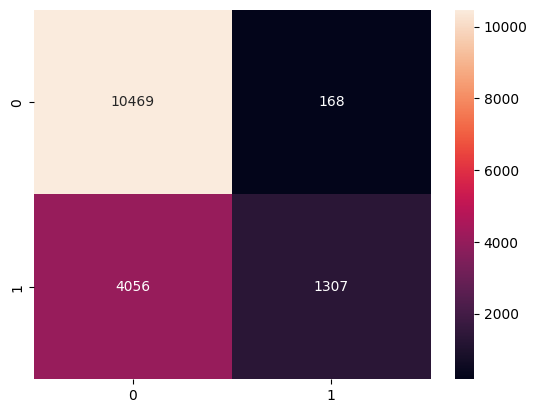

In [66]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="")

In [67]:
y_pred_train = svm.predict(X_train)
accuracy_score(y_train, y_pred_train)

0.739921875

In [71]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_std = scaler.transform(X_train)

In [72]:
svm = SVC(kernel='rbf')
svm.fit(X_std, y_train)

SVC()

In [76]:
X_std_test = scaler.transform(X_test)
y_pred = svm.predict(X_std_test)
accuracy_score(y_test, y_pred)

0.7619375

<AxesSubplot: >

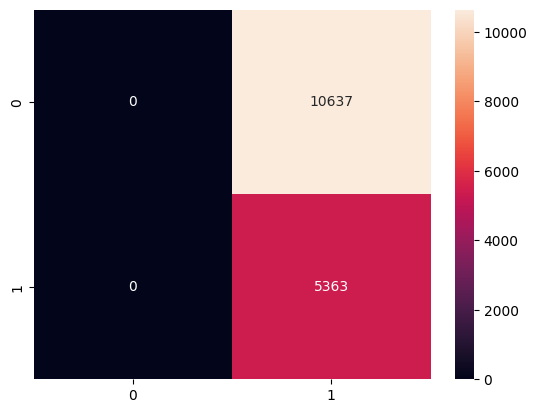

In [74]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="")

In [77]:
y_pred_train = svm.predict(X_std)
accuracy_score(y_train, y_pred_train)

0.77615625